# Temat: Określenie czy dana osoba zarabia więcej niż 50tyś dolarów rocznie.

Autorzy: Mariusz Rebandel, Jakub Typiński

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
adult = pd.read_csv("adult.csv")

## 1. Omówienie tematu

Badamy dane dotyczące zarobków w Ameryce w roku 1994. Do naszej dyspozycji dostaliśmy tabelę przedstawiającą ponad 32 tysiące  <br> osób. Każda z nich jest określona przez kilkanaście parametrów: <br>
age - wiek badanej osoby {dana numeryczna}<br>
workclass - gałąź przemysłu, w której badana osoba pracuje {Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked} <br>
{dana numeryczna} fnlwgt - przypuszczana ilość ludności, która reprezentuje osoby o podanych w tym samym wierszu charakterystykach ( według spisu ludności )<br>
education - stopień wykształcenia {Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool}<br> 
{dana numeryczna} education.num - ranga wykształcenia<br>
martial status - stan cywilny {Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse}<br>
occupation - zawód w jakim dana osoba pracuje {Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces}<br>
relationship - kolumna okeślająca powiązania osoby z rodziną  {Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried}<br> 
race - rasa  {White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black}<br> 
sex - płeć biologiczna {Female, Male} <br> 
{dana numeryczna} capital.gain - środki zyskane z inwestycji<br> 
{dana numeryczna} capital.loss - środki stracone<br> 
{dana numeryczna} hours.per.week - określenie ile godzin dana osoba spędza tygodniowo w pracy <br> 
native.country- kraj pochodzenia {United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands}
<br> income - określenie czy osoba zarabia 50 tys dolarów crocznie czy nie {>50K, <=50K} <br>

## 2. Wstępne przygotowanie danych

### 2.1 Uzupełnienie i usunięcie pustych danych

Poniżej znajduje się skrypt badający wypełnienie poszczególnych kolumn

Rozmiar: 32561 wierszy.


/home/mariusz/anaconda2/lib/python2.7/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


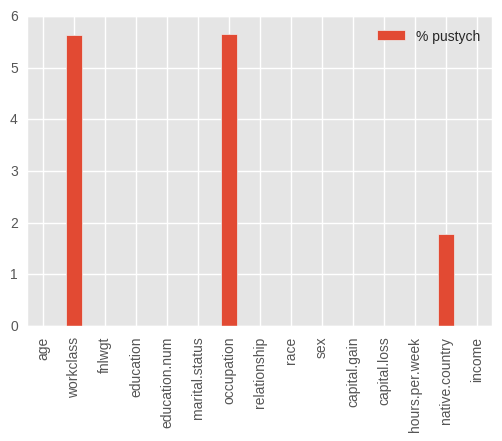

In [2]:
size = len(adult)
print "Rozmiar:", size, "wierszy."
frame = pd.DataFrame(index = adult.columns)
for col in adult.columns:
    empty = 0
    try:
        empty = len(adult.loc[adult[col] == '?'])
    except:
        empty = len(adult.loc[adult[col] == np.NaN])
    percentage = float(empty)*100.0/float(size)
    frame.set_value(col, '% pustych', percentage)
frame.transpose()
frame.plot(kind='bar')
plt.show()

Jak widać, jedynymi kolumnami posiadającymi puste pola są te określające segment rynku, zawód i kraj pochodzenia. Ponadto widać podobną ilość pustych pól w kategoriach segmentu rynku i zatrudnienia, co każe sądzić że są w jakiś sposób ze sobą skorelowane.

In [3]:
dat = [len(adult.loc[adult['workclass'] == '?']), len(adult.loc[adult['occupation'] == '?']),
     len(adult.loc[adult['workclass'] == '?'].loc[adult['occupation'] == '?'])]
ind = ["Segment rynku", "Zawód", "Obydwa"]
pd.DataFrame(index=ind, data=dat, columns=['Nie podano razy'])

,Nie podano razy
Segment rynku,1836
Zawód,1843
Obydwa,1836


Jak widać w każdym wypadku nie podania segmentu rynku badany nie podawał także uprawianego zawodu. Poniżej znajduje się analiza ilości niezatrudnionych osób względem wieku.

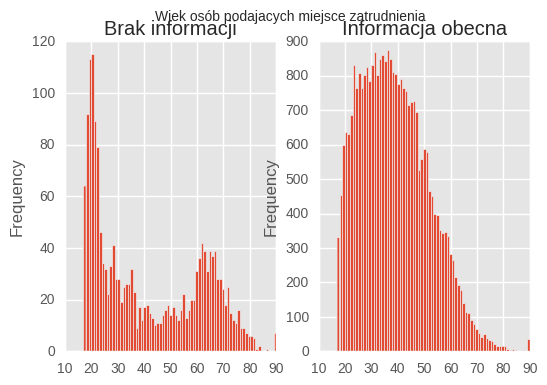

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
df1 = adult.loc[adult['workclass'] == '?'].loc[adult['occupation'] == '?'].sort_values(by=['age'])
dfh1 = df1['age'].plot.hist(bins=(90-16), title = 'Brak informacji', ax=ax1)
df2 = adult.loc[adult['workclass'] != '?'].loc[adult['occupation'] != '?'].sort_values(by=['age'])
dfh2 = df2['age'].plot.hist(bins=(90-16), title = 'Informacja obecna', ax=ax2)
fig.suptitle(u"Wiek osób podajacych miejsce zatrudnienia")
plt.show()

Na powyższym wykresie widać duży odsetek osób niezatrudnionych w wieku ok. 20 lat i osób po 60 roku życia. Każe to sądzić, że osoby w wieku 20 lat jeszcze się uczą, natomiast z opracowań statystycznych wynika, że w latach 90. przeciętna wieku przejścia na emeryturę w Ameryce wynosiła 62 lata, zarówno dla kobiet jak i mężczyzn, co potwierdza przypuszczenia, że osoby niepodające zatrudnienia po 60 roku życia to emeryci. Oznacza to, że nie podanie zatrudnienia to brak pracy. Można zauważyć inny rozkład na wykresie z osobami podającymi miejsce zatrudnienia. Dlatego osobom posiadającym znak '?' przypisujemy wartość 'None' oznaczającą aktualny brak zatrudnienia.

In [5]:
adult = adult.drop(adult.loc[adult["occupation"] == '?'].loc[adult["workclass"] != '?'].index)
adult['occupation'] = adult['occupation'].replace(to_replace='?', value='None')
adult['workclass'] = adult['workclass'].replace(to_replace='?', value='None')

Usuwamy wszystkie wiersze, gdzie wprowadzono segment rynku, a nie wprowadzono zawodu. Jest ich znikoma liczba, więc nie wpłynie to znacząco na wyniki badań.

Pozostała kwestia narodowości. Uzupełnione zostaną one najczęściej występującym krajem pochodzenia osób tej samej rasy.

In [6]:
mcc = {}; "Najczęstsze kraje pochodzenia"
for x in adult["race"].unique():
    series = adult.loc[adult["race"] == x]["native.country"]
    counts = series.value_counts()
    mcc[x] = counts.index[0]
    print u"Najczęstszy kraj rasy",x,":",counts.index[0],"(",counts.max(),"/",counts.sum(),")"

Najczęstszy kraj rasy White : United-States ( 25616 / 27811 )
Najczęstszy kraj rasy Black : United-States ( 2830 / 3122 )
Najczęstszy kraj rasy Asian-Pac-Islander : United-States ( 292 / 1039 )
Najczęstszy kraj rasy Other : United-States ( 129 / 271 )
Najczęstszy kraj rasy Amer-Indian-Eskimo : United-States ( 296 / 311 )


In [7]:
for x in mcc.keys():
    adult.loc[(adult["race"] == x) & (adult["native.country"] == "?"), "native.country" ] = mcc[x]

Po zastąpieniu najczęstszymi krajami pochodzenia ludzi różnych ras są:

In [8]:
for x in adult["race"].unique():
    series = adult.loc[adult["race"] == x]["native.country"]
    counts = series.value_counts()
    print u"Najczęstszy kraj rasy",x,":",counts.index[0],"(",counts.max(),"/",counts.sum(),")"

Najczęstszy kraj rasy White : United-States ( 26002 / 27811 )
Najczęstszy kraj rasy Black : United-States ( 2926 / 3122 )
Najczęstszy kraj rasy Asian-Pac-Islander : United-States ( 375 / 1039 )
Najczęstszy kraj rasy Other : United-States ( 147 / 271 )
Najczęstszy kraj rasy Amer-Indian-Eskimo : United-States ( 296 / 311 )


## 2.2 Usunięcie zbędnych kolumn

In [9]:
print ( "osoby, które ukończyły szkołę na poziomie HS-grad:")
print (adult['education'].loc[adult['education']=='HS-grad'].count())
print ( "osoby, które ukończyły szkołę na poziomie HS-grad oraz uczyły się 9 lat:")
print (adult['education'].loc[adult['education']=='HS-grad'].loc[adult['education.num']==9].count())

osoby, które ukończyły szkołę na poziomie HS-grad:
10500
osoby, które ukończyły szkołę na poziomie HS-grad oraz uczyły się 9 lat:
10500


In [10]:
print ( "osoby, które ukończyły szkołę na poziomie Some-college:")
print (adult['education'].loc[adult['education']=='Some-college'].count())
print ( "osoby, które ukończyły szkołę na poziomie Some-college oraz uczyły się 10 lat:")
print (adult['education'].loc[adult['education']=='Some-college'].loc[adult['education.num']==10].count())

osoby, które ukończyły szkołę na poziomie Some-college:
7289
osoby, które ukończyły szkołę na poziomie Some-college oraz uczyły się 10 lat:
7289


Powyższa obserwacja pozwala nam zauważyć, że kolumny "education" oraz "education.num" przedstawiają tę samą informację zapisaną jedynie w sposób opisowy oraz numeryczny

In [11]:
del adult["fnlwgt"]

Zdecydowaliśmy się na usunięcie kolumny fnlwgt, gdyż uznaliśmy że ma znikomy wpływ na wyniki badania

## 2.3 Zgrupowanie danych

In [12]:
adult["native.country"].value_counts()

United-States                 29746
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [13]:
countries = {
    'United-States' : 'North America',
    'Mexico'        : 'South America',
    'Philippines'   : 'Asia',
    'Germany'       : 'Europe',
    'Canada'        : 'North America',
    'Puerto-Rico'   : 'South America',
    'El-Salvador'   : 'South America',
    'India'         : 'Asia',
    'Cuba'          : 'South America',
    'England'       : 'Europe',
    'Jamaica'       : 'South America',
    'South'         : 'South America',
    'China'         : 'Asia',
    'Italy'         : 'Europe',
    'Dominican-Republic' : 'South America',
    'Vietnam'       : 'Asia',
    'Guatemala'     : 'South America',
    'Japan'         : 'Asia',
    'Poland'        : 'Europe',
    'San Escobar'   : 'South America',
    'Columbia'      : 'South America',
    'Taiwan'        : 'Asia',
    'Haiti'         : 'South America',
    'Iran'          : 'Asia',
    'Portugal'      : 'Europe',
    'Nicaragua'     : 'South America',
    'Peru'          : 'South America',
    'France'        : 'Europe',
    'Greece'        : 'Europe',
    'Ecuador'       : 'South America',
    'Ireland'       : 'Europe',
    'Hong'          : 'Asia',
    'Trinadad&Tobago':'South America',
    'Cambodia'      : 'Asia',
    'Laos'          : 'Asia',
    'Thailand'      : 'Asia',
    'Yugoslavia'    : 'Europe',
    'Outlying-US(Guam-USVI-etc)':'North America',
    'Hungary'       : 'Europe',
    'Honduras'      : 'South America',
    'Scotland'      : 'Europe',
    'Holand-Netherlands': 'Europe'
}

for x in countries.keys():
    adult.loc[adult["native.country"] == x, "native.country"] = countries[x]

In [14]:
adult['native.country'].value_counts()

North America    29881
South America     1481
Asia               671
Europe             521
Name: native.country, dtype: int64

Postanowiliśmy pogrupować państwa według ich przynależności do kontynentów, aby zmniejszyć ilość atrybutów, z którą będziemy pracować, co równocześnie wpływa na zwiększenie ich wpływu na badanie, gdyż przytłaczająca ilość wyników pochodzi z samych tylko Stanów Zjednoczonych.

# 3. Analiza danych

## 3.1 Procentowy skład grup społecznych zarabiających powyżej 50 tysięcy dolarów

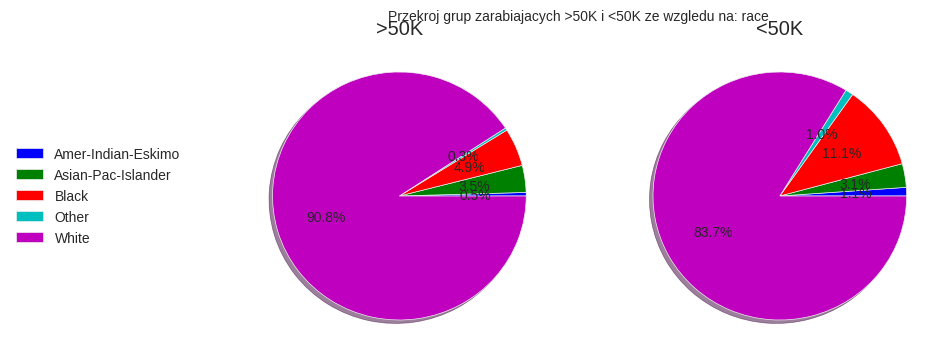

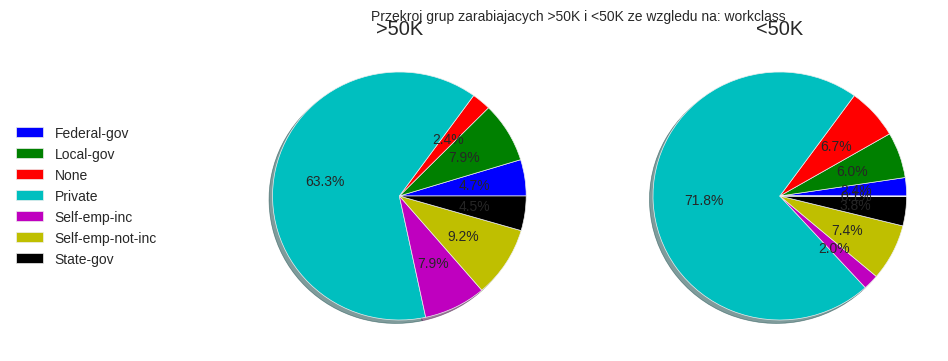

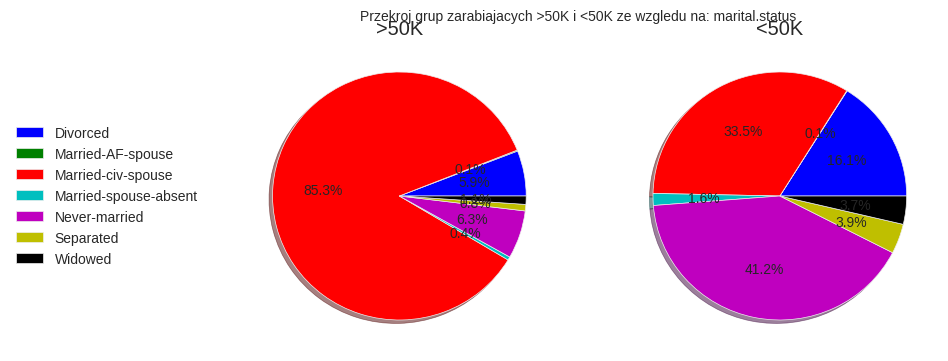

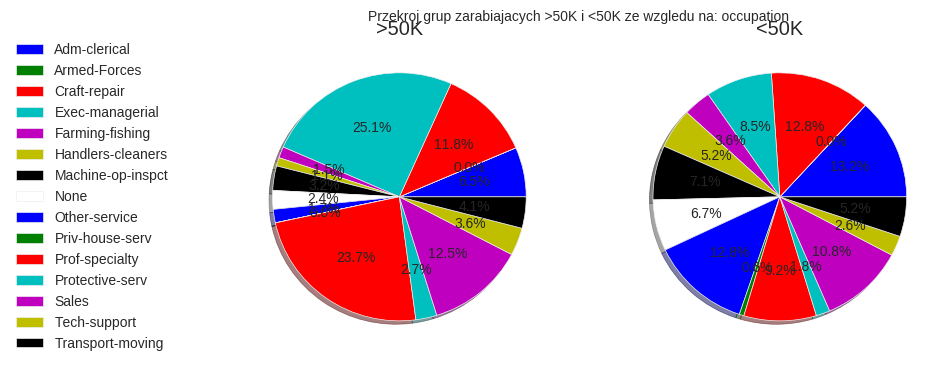

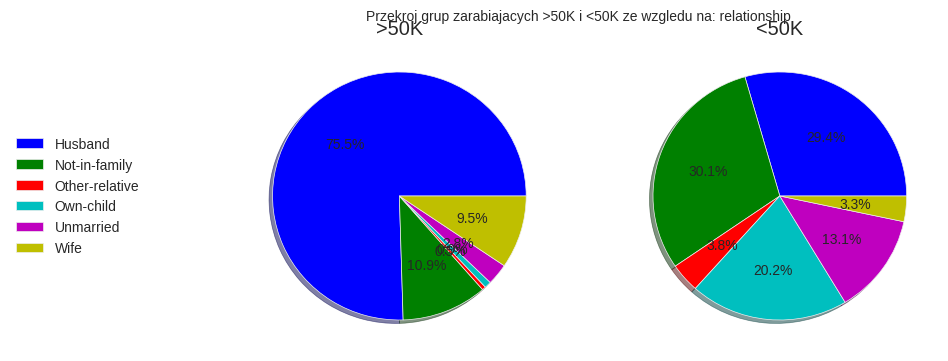

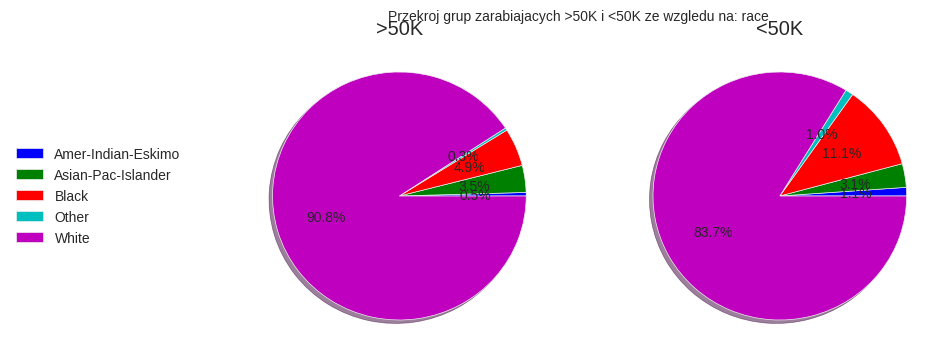

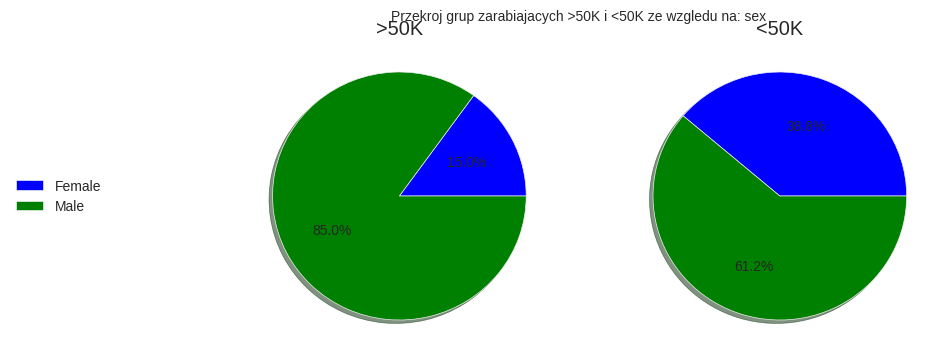

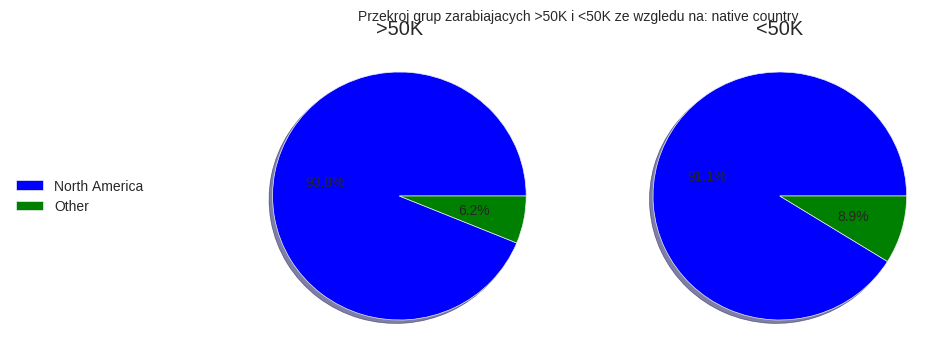

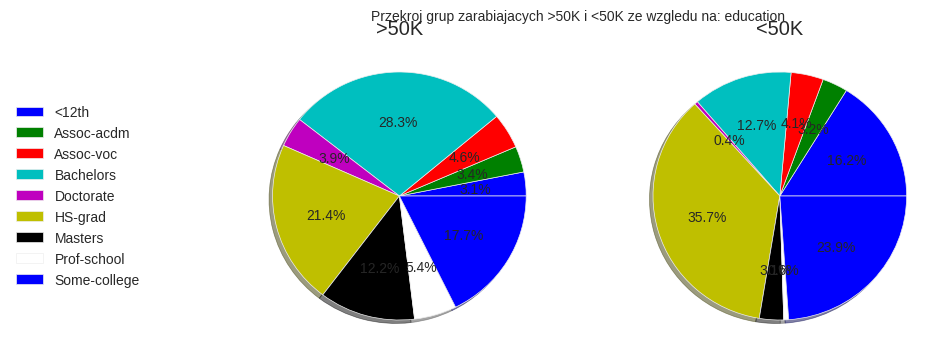

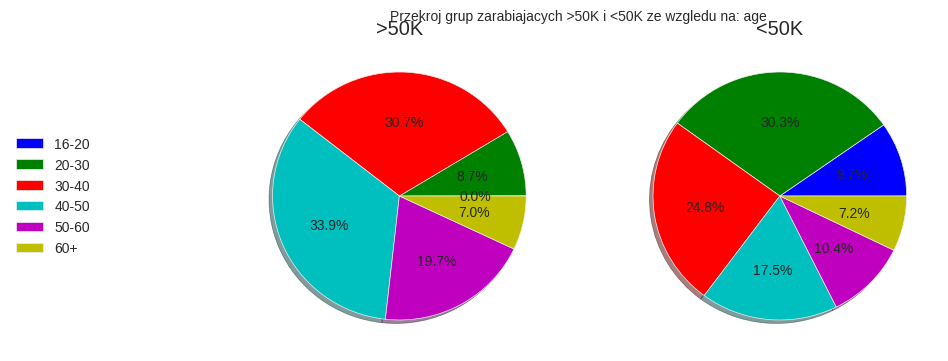

In [15]:
from matplotlib import gridspec

def plotpair(title, series1, series2):
    plt.figure(figsize=(9,4))
    plt.suptitle("Przekroj grup zarabiajacych >50K i <50K ze wzgledu na: "+title)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    series = series1.value_counts()
    series = series.sort_index();
    ax1 = plt.subplot(gs[0])
    labels = [""]*len(series)
    #labels = series.index
    ax1.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
    labels = series.index
    ax1.legend(loc='center left', shadow=True, bbox_to_anchor=(-0.75, 0.5), labels=labels)
    ax1.xaxis.set_visible(False)
    ax1.set_title(">50K")

    series = series2.value_counts()
    series = series.sort_index();
    ax2 = plt.subplot(gs[1])
    labels = [""]*len(series)
    ax2.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
    ax2.set_title("<50K")

    plt.show()

columns = ["race", "workclass", "marital.status", "occupation", "relationship", "race", "sex"]

for x in columns:
    plotpair(x, adult.loc[adult["income"] == ">50K"][x], adult.loc[adult["income"] != ">50K"][x])
    
df1 = adult.copy()
df1.loc[df1["native.country"] != "North America", "native.country"] = "Other"
plotpair("native country", df1.loc[df1["income"] == ">50K"]["native.country"], df1.loc[df1["income"] != ">50K"]["native.country"])

df1.loc[df1["education.num"] <= 8, "education"] = "<12th"
plotpair("education", df1.loc[df1["income"] == ">50K"]["education"], df1.loc[df1["income"] != ">50K"]["education"])


df1.loc[df1["age"] > 60, "age1"] = "60+"
df1.loc[(df1["age"] > 50) & (df1["age"] <= 60), "age1"] = "50-60"
df1.loc[(df1["age"] > 40) & (df1["age"] <= 50), "age1"] = "40-50"
df1.loc[(df1["age"] > 30) & (df1["age"] <= 40), "age1"] = "30-40"
df1.loc[(df1["age"] > 20) & (df1["age"] <= 30), "age1"] = "20-30"
df1.loc[(df1["age"] > 10) & (df1["age"] <= 20), "age1"] = "16-20"
plotpair("age", df1.loc[df1["income"] == ">50K"]["age1"], df1.loc[df1["income"] != ">50K"]["age1"])


Aalizując powyższe wykresy kołowe dochodzimy do kilku ciekawych wniosków. W przypadku rasy - tylko około jedna trzecia czarnych ludzi stanowi grupę zarabiającą powyżej 50 tysięcy dolarów. Zdecydowaną większość osób zarabiających powyżej jak i poniżej (ok. 70%) stanowią ludzie pracujący w sektorze prywatnym. Osoby bez zatrudnienia stanowią 6.4% osób zarabiających poniżej 50 tys. dolarów, a powyżej - tylko 2.7%. Jeśli chodzi o stan cywilny to bardzo pozytywny wpływ na zarabienie wyznaczonej kwoty ma bycie żonatym/zamężną. Przeciwnie sytuacja się przedstawia w przypadku rozwodów i kawalerów oraz panien. W stosunku do rodziny - posiadanie dziecka, oraz nieposiadanie rodziny są cechami negatywnymi, natomiast bycie mężem - bardzo pozytywne. Ostatnie spostrzeżenia dotyczą następującego faktu - osoby przed 20 rokiem życia praktycznie nie występują w grupie zarabiającej ponad 50 tys. dolarów.

## 3.2 Badanie korelacji

In [16]:
adult.corr()

,age,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,0.036241,0.077649,0.057725,0.068474
education.num,0.036241,1.000000,0.122621,0.079890,0.148017
capital.gain,0.077649,0.122621,1.000000,-0.031622,0.078397
capital.loss,0.057725,0.079890,-0.031622,1.000000,0.054224
hours.per.week,0.068474,0.148017,0.078397,0.054224,1.000000


Kolumny numeryczne nie są ze sobą w żaden szczególny sposób skorelowane, po za być może wpływem poziomu wykształcenia na ilość przepracowanych godzin w tygodniu i przychodami z kapitału.

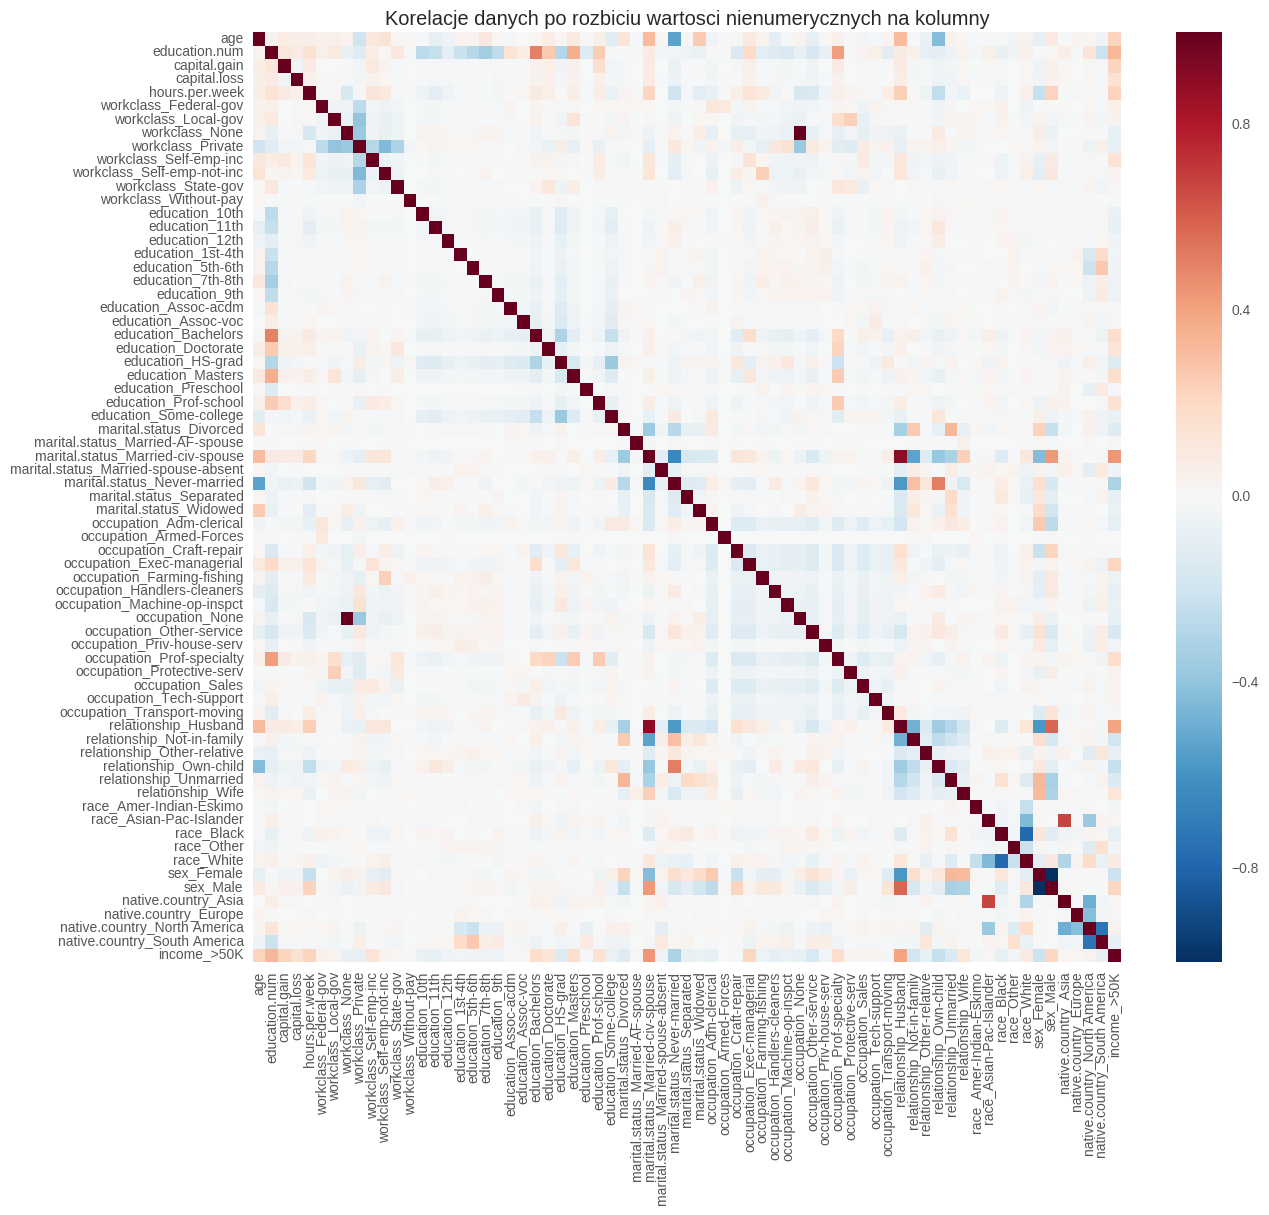

In [17]:
binary_data = pd.get_dummies(adult)
del binary_data['income_<=50K']
plt.subplots(figsize=(14,12))
plt.title('Korelacje danych po rozbiciu wartosci nienumerycznych na kolumny')
sns.heatmap(binary_data.corr())
plt.show()

W powyższym fragmencie rozbiliśmy każdą wartość nienumeryczną na osobne kolumny o wartościach 0-1, tak żeby pokazać korelację między wszystkimi możliwymi atrybutami występującymi w kolumnach nienumerycznych. Informacje uzyskane w ten sposób można podzielić na 2 kategorie - oczywiste oraz nieoczywiste.<br>
Do oczywistych zaliczamy np.: <br>
sex_male jest całkowicie negatywnie skorelowane z sex_female, <br>
relationship_husband jest silnie skorelowane z martial.status_Married-civ-spouse, itp. <br>
Do nieoczywistych natomiast zaliczamy:<br>
martial.status_Never-married ma negatywną korelację z wiekiem <br>
relationship_Own-child ma negatywną korelację z wiekiem<br>
Pozostałe korelacje są na tyle słabe że o nich nie wspominamy
Ponadto usunęliśmy kolumnę oznaczającą zarobki poniżej 50 tys dolarów, ze względu na całkowicie negatywne skorelowanie z kolumną z zarobkami powyżej 50 tys dolarów.

Dane przedstawiliśmy na wykresie cieplnym, ponieważ w formie tabeli są one całkowicie nieczytelne.

# 4. Klasyfikacja

In [18]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics

def drawCoefs(model):
    plt.figure(figsize=(15,5))
    coefs = pd.Series(model.coef_[0], index=X_train.columns)
    coefs = coefs.sort_values(ascending=False)
    coefs.plot(kind="bar")
    plt.show()
    
def drawPred(model):
    y_pred = model.predict(X_test)
    print "Błąd klasyfikacji:", 1.0-model.score(X_test,y_test)
    print metrics.classification_report(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(data=cm, columns=["Przewidywane <=50K", "Przewidywane >50K"], index=["Rzeczywiste <=50K", "Rzeczywiste >50K"])
    print df
    #print "\nMiara F: %f" % skl.metrics.f1_score(y_test, y_pred)

bd_without_income = binary_data.copy()
del bd_without_income["income_>50K"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(bd_without_income, binary_data["income_>50K"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)



## 4.1 Naiwny Baynes

In [19]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(X_train, y_train)

drawPred(nb)

Błąd klasyfikacji: 0.377086106276
             precision    recall  f1-score   support

        0.0       0.97      0.53      0.68      7493
        1.0       0.38      0.94      0.54      2274

avg / total       0.83      0.62      0.65      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                3952               3541
Rzeczywiste >50K                  142               2132


Klasyfikacja metodą Naiwnego Baynesa dała nam skuteczność przewidywania około 62%, co nie jest bardzo dobrym wynikiem

## 4.2 Drzewa Decyzyjne

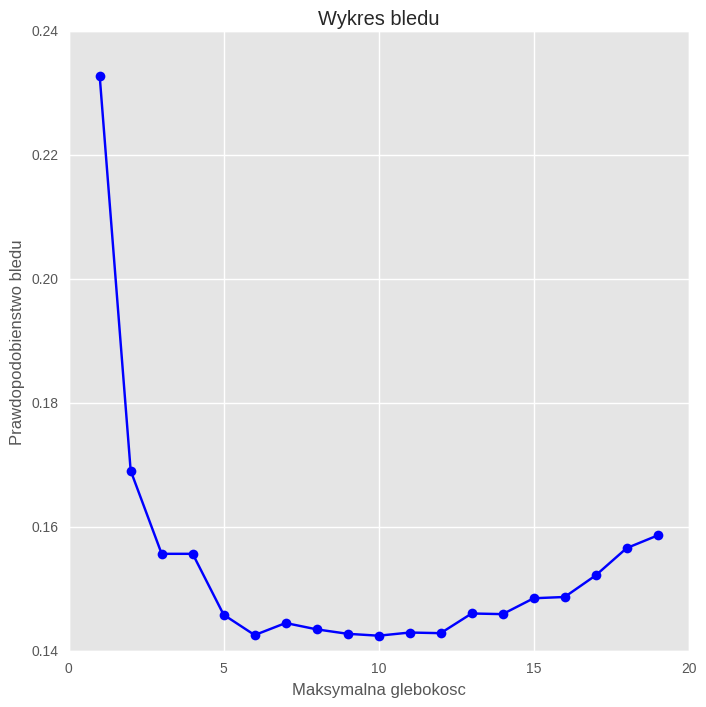

Zalecana glebokosc: 10 Błąd:  0.142520733081


In [20]:
from sklearn import tree
kvals = range(1, 20)
rss_all = np.zeros(19)
minval = 1.0
depth = 0
for k in kvals:
    mtree = tree.DecisionTreeClassifier(max_depth=k)
    mtree.fit(X_train, y_train)
    predictions = mtree.predict(X_test)
    error = 1-mtree.score(X_test,y_test)    
    rss_all[k-1] = error
    if error < minval:
        minval = error
        depth = k
plt.figure(figsize=(8,8))
plt.plot(kvals, rss_all,'bo-')
plt.title('Wykres bledu')
plt.xlabel(u'Maksymalna glebokosc')
plt.ylabel('Prawdopodobienstwo bledu')
plt.show()

print 'Zalecana glebokosc:', depth, 'Błąd: ', minval

In [21]:
from sklearn import tree

mtree = tree.DecisionTreeClassifier(max_depth=depth)
mtree.fit(X_train, y_train)

drawPred(mtree)

Błąd klasyfikacji: 0.142930275417
             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91      7493
        1.0       0.76      0.57      0.65      2274

avg / total       0.85      0.86      0.85      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                7086                407
Rzeczywiste >50K                  989               1285


Klasyfikacja za pomocą drzew decyzyjnych okazała się skuteczniejsza niż metoda Naiwnego Bayesa, dając skuteczność przewidywań już 86% przy optymalnej głębokości drzewa - 10. Co ciekawe zalecana głębokość drzewa jest zmienna w zależności od uruchomienia skryptu, jednak oscyluje ona między 8 i 11. W naszym przypadku było to 10.

## 4.3 Metoda najbliższych sąsiadów

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)

drawPred(knn)

Błąd klasyfikacji: 0.16791235794
             precision    recall  f1-score   support

        0.0       0.86      0.94      0.90      7493
        1.0       0.71      0.47      0.57      2274

avg / total       0.82      0.83      0.82      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                7047                446
Rzeczywiste >50K                 1194               1080


Bardzo powolne obliczenia wywołane obszernością tablicy. Nieefektywna dla tego problemu. Mimo dość wysokiej skuteczności przewidywań.

## 4.4 Regresja logistyczyczna

In [23]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)

drawPred(cls)

Błąd klasyfikacji: 0.147025698782
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.91      7493
        1.0       0.73      0.59      0.65      2274

avg / total       0.85      0.85      0.85      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                6984                509
Rzeczywiste >50K                  927               1347


Klasyfikacja za pomocą regresji logistycznej okazała się niemal tak samo skuteczna jak przy użyciu drzew decyzyjnych

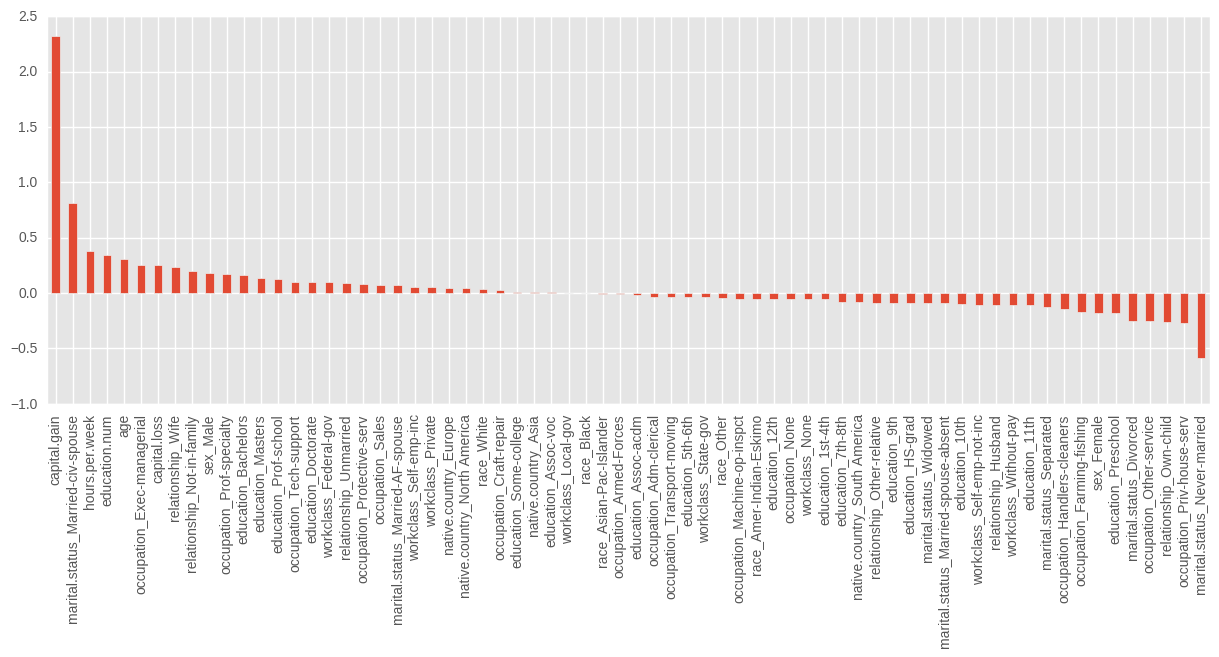

In [24]:
drawCoefs(cls)

Powyższy diagram pokazuje nam po kolei współczynniki wpływu poszczególnych cech na uzyskiwanie powyżej 50 tys. dolarów rocznie, a które negatywnie.

# 5. Podsumowanie

Analizując wszystkie wyniki dochodzimy do wniosku, że czynnikiem wpływającym najbardziej na zarobki powyżej 50 tys dolarów rocznie jest zysk z kapitału. Kolejne bardzo istotne czynniki to: bycie zamężną/żonatym oraz godziny pracy w tygodniu i wiek ( im więcej tym lepiej ). Widać również wpływ wykształcenia. Przynależność rasowa nie wykazuje istotnego wpływu na możliwość zarabiania powyżej 50 tys dolarów rocznie.  Najbardziej negatywnie wpływającymi czynnikami są kolejno: bycie panną/kawalerem, zakończenie edukacji na edukacji przedszkolnej, praca w usługach (innych), posiadanie dziecka, bycie rozwodnikiem, praca w rolnictwie oraz co ciekawe bycie kobietą.

Najabardziej efektywnymi klasyfikatorami dla tego problemu okazały się drzewa decyzyjne oraz dokonanie regresji logistycznej. Metoda najbliższych sąsiadów okazała się dla tego problemu nieefektywna ze względu na dużą ilość kategorii powstałą po rozbiciu danych nienumerycznych na osobne kolumny o wartościach binarnych.
